In [ ]:
!pip install fingerprint_enhancer
import fingerprint_enhancer
# !pip install fingerprint-feature-extractor
# import fingerprint_feature_extractor
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from skimage.morphology import skeletonize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fingerprint-enhancer: filename=fingerprint_enhancer-0.0.12-py3-none-any.whl size=8059 sha256=bf4cec7d6531237fbef066f4239b5915013db0ef69ebcbadcb12a0b16ac42b2e
  Stored in directory: /root/.cache/pip/wheels/c1/10/92/54ee2fcda0ca17304e47e2bc2e20542a6c92fbfc668c6aeba7
Successfully built fingerprint-enhancer


In [ ]:
def filter_mask(img):
  # Calculate the local gradient (using Sobel filters)
  gx, gy = cv.Sobel(img, cv.CV_32F, 1, 0), cv.Sobel(img, cv.CV_32F, 0, 1)
  # Calculate the magnitude of the gradient for each pixel
  gx2, gy2 = gx**2, gy**2
  gm = np.sqrt(gx2 + gy2)
  # Integral over a square window
  sum_gm = cv.boxFilter(gm, -1, (25, 25), normalize = False)
  # Use a simple threshold for segmenting the fingerprint pattern
  thr = sum_gm.max() * 0.2
  mask = cv.threshold(sum_gm, thr, 255, cv.THRESH_BINARY)[1].astype(np.uint8)
  # A 1-pixel background border is added to the mask before computing the distance transform
  mask_distance = cv.distanceTransform(cv.copyMakeBorder(mask, 1, 1, 1, 1, cv.BORDER_CONSTANT), cv.DIST_C, 3)[1:-1,1:-1]
  return mask_distance

In [ ]:
def enhancer(img):
  enhanced = fingerprint_enhancer.enhance_Fingerprint(img)		# enhance the fingerprint image
  # plt.imshow(enhanced)
  return enhanced

In [ ]:
def convert_to_3d(img):
  res=np.empty([img.shape[0],img.shape[1],3])
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i,j]==0:
        res[i,j]=[255,255,255]
      else:
        res[i,j]=[0,0,0]
  # plt.imshow(res)
  return res

In [ ]:
def binarize(img):
  _,bin = cv.threshold(img, 100, 255, cv.THRESH_BINARY)
  # plt.imshow(cv.cvtColor(res, cv.COLOR_RGB2BGR))
  return bin

In [ ]:
def skeletonize(img):
  skeleton = cv.ximgproc.thinning(img, thinningType = cv.ximgproc.THINNING_GUOHALL)
  # plt.imshow(cv.cvtColor(skeleton, cv.COLOR_RGB2BGR))
  return skeleton

In [ ]:
# FeaturesTerminations, FeaturesBifurcations = fingerprint_feature_extractor.extract_minutiae_features(out, spuriousMinutiaeThresh=10, invertImage=False, showResult=True, saveResult=True)

# Minutiae detection

In [ ]:
# Utility function to draw a set of minutiae over an image
def draw_minutiae(fingerprint, minutiae, termination_color = (255,0,0), bifurcation_color = (0,0,255)):
    res = cv.cvtColor(fingerprint, cv.COLOR_GRAY2BGR)
    
    for x, y, t, *d in minutiae:
        color = termination_color if t else bifurcation_color
        if len(d)==0:
            cv.drawMarker(res, (x,y), color, cv.MARKER_CROSS, 5)
        # else:
        #     cv.drawMarker(res, (x,y), color, cv.MARKER_CROSS, 1)
        else:
            d = d[0]
            ox = int(round(math.cos(d) * 3))
            oy = int(round(math.sin(d) * 3))
            cv.circle(res, (x,y), 2, color, 3, cv.LINE_AA)
            cv.line(res, (x,y), (x+ox,y-oy), color, 3, cv.LINE_AA)        
    return res

In [ ]:
def compute_crossing_number(values):
    return np.count_nonzero(values < np.roll(values, -1))

In [ ]:
# Create a filter that converts any 8-neighborhood into the corresponding byte value [0,255]
cn_filter = np.array([[  1,  2,  4],
                      [128,  0,  8],
                      [ 64, 32, 16]
                    ])
# Create a lookup table that maps each byte value to the corresponding crossing number
all_8_neighborhoods = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
cn_lut = np.array([compute_crossing_number(x) for x in all_8_neighborhoods]).astype(np.uint8)
def minutiae_generator(skeleton):
  # Skeleton: from 0/255 to 0/1 values
  skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
  # Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
  cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
  # Apply the lookup table to obtain the crossing number of each pixel
  cn = cv.LUT(cn_values, cn_lut)
  # Keep only crossing numbers on the skeleton
  cn[skeleton==0] = 0

  # crossing number == 1 --> Termination, crossing number == 3 --> Bifurcation
  minutiae = [(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]

  return minutiae

NameError: ignored

# Orientation of minutiae points

In [ ]:
def compute_next_ridge_following_directions(previous_direction, values):    
    next_positions = np.argwhere(values!=0).ravel().tolist()
    if len(next_positions) > 0 and previous_direction != 8:
        # There is a previous direction: return all the next directions, sorted according to the distance from it,
        #                                except the direction, if any, that corresponds to the previous position
        next_positions.sort(key = lambda d: 4 - abs(abs(d - previous_direction) - 4))
        if next_positions[-1] == (previous_direction + 4) % 8: # the direction of the previous position is the opposite one
            next_positions = next_positions[:-1] # removes it
    return next_positions

In [ ]:
import math
r2 = 2**0.5 # sqrt(2)

# The eight possible (x, y) offsets with each corresponding Euclidean distance
xy_steps = [(-1,-1,r2),( 0,-1,1),( 1,-1,r2),( 1, 0,1),( 1, 1,r2),( 0, 1,1),(-1, 1,r2),(-1, 0,1)]

nd_lut = [[compute_next_ridge_following_directions(pd, x) for pd in range(9)] for x in all_8_neighborhoods]

In [ ]:
def follow_ridge_and_compute_angle(x, y,cn_values,skeleton, d = 8):
    px, py = x, y
    length = 0.0
    # Apply the lookup table to obtain the crossing number of each pixel
    cn = cv.LUT(cn_values, cn_lut)
    # Keep only crossing numbers on the skeleton
    cn[skeleton==0] = 0
    while length < 20: # max length followed
        next_directions = nd_lut[cn_values[py,px]][d]
        if len(next_directions) == 0:
            break
        # Need to check ALL possible next directions
        if (any(cn[py + xy_steps[nd][1], px + xy_steps[nd][0]] != 2 for nd in next_directions)):
            break # another minutia found: we stop here
        # Only the first direction has to be followed
        d = next_directions[0]
        ox, oy, l = xy_steps[d]
        px += ox ; py += oy ; length += l
    # check if the minimum length for a valid direction has been reached
    return math.atan2(-py+y, px-x) if length >= 10 else None

In [ ]:
# Utilities for angle arithmetics
def angle_abs_difference(a, b):
    return math.pi - abs(abs(a - b) - math.pi)

def angle_mean(a, b):
    return math.atan2((math.sin(a)+math.sin(b))/2, ((math.cos(a)+math.cos(b))/2))

In [ ]:
def minutiae_angles(minutiae, skeleton):
  minutiae_angle = []
  # Skeleton: from 0/255 to 0/1 values
  skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
  # Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
  cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
  for x, y, term in minutiae:
      d = None
      if term: # termination: simply follow and compute the direction        
          d = follow_ridge_and_compute_angle(x, y, cn_values, skeleton)
      else: # bifurcation: follow each of the three branches
          dirs = nd_lut[cn_values[y,x]][8] # 8 means: no previous direction
          if len(dirs)==3: # only if there are exactly three branches
              angles = [follow_ridge_and_compute_angle(x+xy_steps[d][0], y+xy_steps[d][1],cn_values,skeleton, d) for d in dirs]
              if all(a is not None for a in angles):
                  a1, a2 = min(((angles[i], angles[(i+1)%3]) for i in range(3)), key=lambda t: angle_abs_difference(t[0], t[1]))
                  d = angle_mean(a1, a2)                
      if d is not None:
          minutiae_angle.append( (x, y, term, d) )
  return minutiae_angle

# Main Code

### Method - 1

152 63 51
180 63 48
154 91 73
160 81 77
178 97 79


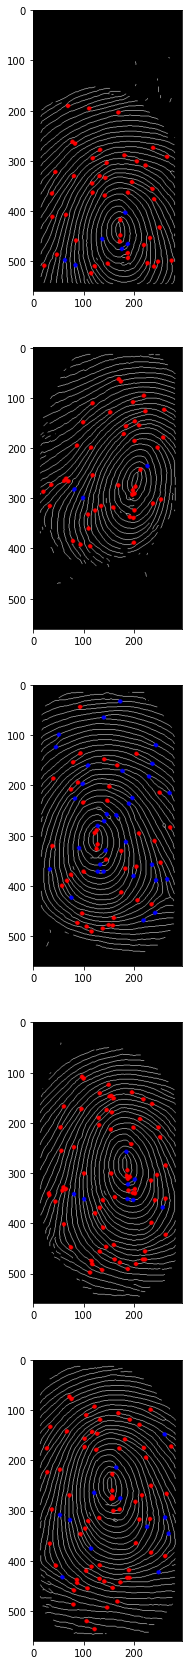

In [ ]:
import glob
fig = plt.figure(figsize=(30,30))
rows = 5
columns = 1
count=1
for img_file in glob.glob('*.tif'):
  img0=cv.imread(img_file,cv.IMREAD_GRAYSCALE)
  img1=skeletonize(binarize(enhancer(img0)))
  fig.add_subplot(rows, columns, count)
  count+=1
  mask = filter_mask(img0)
  # minutiae_pts_arr = minutiae_points(img1)
  minutiae_pts_arr = minutiae_generator(img1)
  filtered_minutiae = list(filter(lambda m: mask[m[1], m[0]]>20, minutiae_pts_arr))
  minutiae_angle = minutiae_angles(filtered_minutiae, img1)
  d=draw_minutiae(img1, minutiae_angle)
  print(len(minutiae_pts_arr),len(filtered_minutiae),len(minutiae_angle))
  plt.imshow(d)

### Method - 2 : Feature_Extractor Library src code

In [ ]:
import cv2
import numpy as np
import skimage.morphology
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import matplotlib.pyplot as plt
import math
import copy
class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation
        self.Type = Type

class FingerprintFeatureExtractor(object):
    def __init__(self):
        self._mask = []
        self._skel = []
        self.minutiaeTerm = []
        self.minutiaeBif = []

    def __skeletonize(self, img):
        img = np.uint8(img > 128)
        self._skel = skimage.morphology.skeletonize(img)
        self._skel = np.uint8(self._skel) * 255
        self._mask = img * 255

    def __computeAngle(self, block, minutiaeType):
        angle = []
        (blkRows, blkCols) = np.shape(block)
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        if (minutiaeType.lower() == 'termination'):
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
                        if (sumVal > 1):
                            angle.append(float('nan'))
            return (angle)

        elif (minutiaeType.lower() == 'bifurcation'):
            (blkRows, blkCols) = np.shape(block)
            CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
            angle = []
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
            if (sumVal != 3):
                angle.append(float('nan'))
            return (angle)

    def __getTerminationBifurcation(self):
        self._skel = self._skel == 255
        (rows, cols) = self._skel.shape
        self.minutiaeTerm = np.zeros(self._skel.shape)
        self.minutiaeBif = np.zeros(self._skel.shape)

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if (self._skel[i][j] == 1):
                    block = self._skel[i - 1:i + 2, j - 1:j + 2]
                    block_val = np.sum(block)
                    if (block_val == 2):
                        self.minutiaeTerm[i, j] = 1
                    elif (block_val == 4):
                        self.minutiaeBif[i, j] = 1

        self._mask = convex_hull_image(self._mask > 0)
        self._mask = erosion(self._mask, square(5))  # Structuing element for mask erosion = square(5)
        self.minutiaeTerm = np.uint8(self._mask) * self.minutiaeTerm

    def __removeSpuriousMinutiae(self, minutiaeList, img, thresh):
        img = img * 0
        SpuriousMin = []
        numPoints = len(minutiaeList)
        D = np.zeros((numPoints, numPoints))
        for i in range(1,numPoints):
            for j in range(0, i):
                (X1,Y1) = minutiaeList[i]['centroid']
                (X2,Y2) = minutiaeList[j]['centroid']

                dist = np.sqrt((X2-X1)**2 + (Y2-Y1)**2)
                D[i][j] = dist
                if(dist < thresh):
                    SpuriousMin.append(i)
                    SpuriousMin.append(j)

        SpuriousMin = np.unique(SpuriousMin)
        for i in range(0,numPoints):
            if(not i in SpuriousMin):
                (X,Y) = np.int16(minutiaeList[i]['centroid'])
                img[X,Y] = 1

        img = np.uint8(img)
        return(img)

    def __cleanMinutiae(self, img):
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(self.minutiaeTerm)
        self.minutiaeTerm = self.__removeSpuriousMinutiae(RP, np.uint8(img), 10)

    def __performFeatureExtraction(self):
        FeaturesTerm = []
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeTerm))

        WindowSize = 2  # --> For Termination, the block size must can be 3x3, or 5x5. Hence the window selected is 1 or 2
        FeaturesTerm = []
        for num, i in enumerate(RP):
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Termination')
            if(len(angle) == 1):
                FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

        FeaturesBif = []
        self.minutiaeBif = skimage.measure.label(self.minutiaeBif, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeBif))
        WindowSize = 1  # --> For Bifurcation, the block size must be 3x3. Hence the window selected is 1
        for i in RP:
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Bifurcation')
            if(len(angle) == 3):
                FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
        return (FeaturesTerm, FeaturesBif)

    def extractMinutiaeFeatures(self, img):
        self.__skeletonize(img)

        self.__getTerminationBifurcation()

        self.__cleanMinutiae(img)

        FeaturesTerm, FeaturesBif = self.__performFeatureExtraction()
        return(FeaturesTerm, FeaturesBif)

    def showResults(self, FeaturesTerm, FeaturesBif):
        
        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255*self._skel
        DispImg[:, :, 1] = 255*self._skel
        DispImg[:, :, 2] = 255*self._skel

        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))
        
        return DispImg


def extract_minutiae_features(img, showResult=False):
    feature_extractor = FingerprintFeatureExtractor()
    FeaturesTerm, FeaturesBif = feature_extractor.extractMinutiaeFeatures(img)

    if(showResult):
        return (feature_extractor.showResults(FeaturesTerm, FeaturesBif),FeaturesTerm,FeaturesBif)

    return(FeaturesTerm, FeaturesBif)

96
68
73
60
97


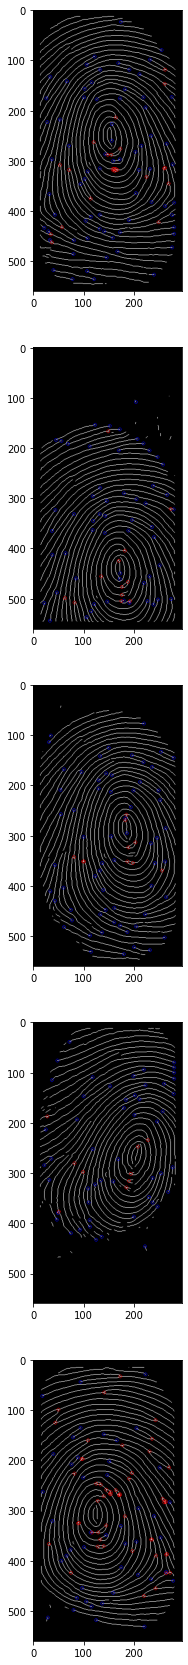

In [ ]:
import glob
fig = plt.figure(figsize=(30,30))
rows = 5
columns = 1
count=1
for img_file in glob.glob('*.tif'):
  img1=cv.imread(img_file,cv.IMREAD_GRAYSCALE)
  img1=enhancer(img1)
  fig.add_subplot(rows, columns, count)
  count+=1
  # FeaturesTerminations, FeaturesBifurcations = extract_minutiae_features(img1, showResult=True)
  # minu = []
  # for i in FeaturesTerminations+FeaturesBifurcations:
  #   minu.append((i.locX,i.locY,i.Orientation,i.Type=='Termination'))
  # mask = filter_mask(img1)
  # d=draw_minutiae(img1, minu)
  # print(len(minu))
  d, FeaturesTerminations, FeaturesBifurcations =extract_minutiae_features(img1, showResult=True)
  print(len(FeaturesTerminations)+len(FeaturesBifurcations))
  plt.imshow(d)

# MCC - Minutiae Cylinder Coding

In [ ]:
T = [[i[0],i[1],i[3]] for i in minutiae_angle]  # x,y,theta of valid minutiae points
print(T)

[[69, 192, 0.3217505543966422], [111, 197, 0.3217505543966422], [169, 205, 0.20749622643520266], [78, 263, -2.427501954977635], [83, 267, 0.6022873461349642], [238, 275, -0.3217505543966422], [133, 279, -2.5829933382462307], [181, 290, -0.15660187698201536], [266, 293, 2.770701364777131], [118, 296, 0.5317240672588056], [206, 302, 2.9340964271545906], [146, 305, -2.539305307454829], [223, 310, -0.3217505543966422], [44, 323, -2.173083672929861], [81, 331, -2.173083672929861], [132, 331, -2.321725389192837], [143, 335, 0.48689923181126904], [196, 343, -0.4182243295792291], [117, 346, 0.7853981633974483], [237, 357, 2.5829933382462307], [118, 364, -2.0576955586061656], [188, 364, -0.6022873461349642], [37, 366, 1.0121970114513341], [142, 370, 0.6435011087932844], [240, 377, -0.9685089806599324], [183, 404, 2.795174446258185], [65, 408, -1.8417431771333173], [38, 412, -1.9890206563741257], [173, 418, -1.1309537439791604], [251, 433, -1.2490457723982544], [173, 449, 1.6207547225168393], [2

In [ ]:
# Compute the cell coordinates of a generic local structure
mcc_radius = 70
mcc_size = 16

g = 2 * mcc_radius / mcc_size
x = np.arange(mcc_size)*g - (mcc_size/2)*g + g/2
y = x[..., np.newaxis]
iy, ix = np.nonzero(x**2 + y**2 <= mcc_radius**2)
ref_cell_coords = np.column_stack((x[ix], x[iy]))

In [ ]:
mcc_sigma_s = 7.0
mcc_tau_psi = 400.0
mcc_mu_psi = 1e-2

def Gs(t_sqr):
    """Gaussian function with zero mean and mcc_sigma_s standard deviation, see eq. (7) in MCC paper"""
    return np.exp(-0.5 * t_sqr / (mcc_sigma_s**2)) / (math.tau**0.5 * mcc_sigma_s)

def Psi(v):
    """Sigmoid function that limits the contribution of dense minutiae clusters, see eq. (4)-(5) in MCC paper"""
    return 1. / (1. + np.exp(-mcc_tau_psi * (v - mcc_mu_psi)))

In [ ]:
# n: number of minutiae
# c: number of cells in a local structure

xyd = np.array([(x,y,d) for x,y,_,d in minutiae_angle]) # matrix with all minutiae coordinates and directions (n x 3)

# rot: n x 2 x 2 (rotation matrix for each minutia)
d_cos, d_sin = np.cos(xyd[:,2]).reshape((-1,1,1)), np.sin(xyd[:,2]).reshape((-1,1,1))
rot = np.block([[d_cos, d_sin], [-d_sin, d_cos]])

# rot@ref_cell_coords.T : n x 2 x c
# xy : n x 2
xy = xyd[:,:2]
# cell_coords: n x c x 2 (cell coordinates for each local structure)
cell_coords = np.transpose(rot@ref_cell_coords.T + xy[:,:,np.newaxis],[0,2,1])

# cell_coords[:,:,np.newaxis,:]      :  n x c  x 1 x 2
# xy                                 : (1 x 1) x n x 2
# cell_coords[:,:,np.newaxis,:] - xy :  n x c  x n x 2
# dists: n x c x n (for each cell of each local structure, the distance from all minutiae)
dists = np.sum((cell_coords[:,:,np.newaxis,:] - xy)**2, -1)

# cs : n x c x n (the spatial contribution of each minutia to each cell of each local structure)
cs = Gs(dists)
diag_indices = np.arange(cs.shape[0])
cs[diag_indices,:,diag_indices] = 0 # remove the contribution of each minutia to its own cells

# local_structures : n x c (cell values for each local structure)
local_structures = Psi(np.sum(cs, -1))

In [ ]:
from ipywidgets import interact
import urllib.request
import IPython
import base64
import html

def show(*images, enlarge_small_images = True, max_per_row = -1, font_size = 0):
  if len(images) == 2 and type(images[1])==str:
      images = [(images[0], images[1])]

  def convert_for_display(img):
      if img.dtype!=np.uint8:
          a, b = img.min(), img.max()
          if a==b:
              offset, mult, d = 0, 0, 1
          elif a<0:
              offset, mult, d = 128, 127, max(abs(a), abs(b))
          else:
              offset, mult, d = 0, 255, b
          img = np.clip(offset + mult*(img.astype(float))/d, 0, 255).astype(np.uint8)
      return img

  def convert(imgOrTuple):
      try:
          img, title = imgOrTuple
          if type(title)!=str:
              img, title = imgOrTuple, ''
      except ValueError:
          img, title = imgOrTuple, ''        
      if type(img)==str:
          data = img
      else:
          img = convert_for_display(img)
          if enlarge_small_images:
              REF_SCALE = 100
              h, w = img.shape[:2]
              if h<REF_SCALE or w<REF_SCALE:
                  scale = max(1, min(REF_SCALE//h, REF_SCALE//w))
                  img = cv.resize(img,(w*scale,h*scale), interpolation=cv.INTER_NEAREST)
          data = 'data:image/png;base64,' + base64.b64encode(cv.imencode('.png', img)[1]).decode('utf8')
      return data, title
    
  if max_per_row == -1:
      max_per_row = len(images)

  rows = [images[x:x+max_per_row] for x in range(0, len(images), max_per_row)]
  font = f"font-size: {font_size}px;" if font_size else ""

  html_content = ""
  for r in rows:
      l = [convert(t) for t in r]
      html_content += "".join(["<table><tr>"] 
              + [f"<td style='text-align:center;{font}'>{html.escape(t)}</td>" for _,t in l]    
              + ["</tr><tr>"] 
              + [f"<td style='text-align:center;'><img src='{d}'></td>" for d,_ in l]
              + ["</tr></table>"])
  IPython.display.display(IPython.display.HTML(html_content))

In [ ]:
def draw_minutiae_and_cylinder(fingerprint, origin_cell_coords, minutiae, values, i, show_cylinder = True):

    def _compute_actual_cylinder_coordinates(x, y, t, d):
        c, s = math.cos(d), math.sin(d)
        rot = np.array([[c, s],[-s, c]])    
        return (rot@origin_cell_coords.T + np.array([x,y])[:,np.newaxis]).T
    
    res = draw_minutiae(fingerprint, minutiae)    
    if show_cylinder:
        for v, (cx, cy) in zip(values[i], _compute_actual_cylinder_coordinates(*minutiae[i])):
            cv.circle(res, (int(round(cx)), int(round(cy))), 3, (0,int(round(v*255)),0), 1, cv.LINE_AA)
    return res

In [ ]:
import glob
for img_file in glob.glob('*.tif'):
  img0=cv.imread(img_file,cv.IMREAD_GRAYSCALE)
  img1=skeletonize(binarize(enhancer(img0)))
  # fig.add_subplot(rows, columns, count)
  # count+=1
  mask = filter_mask(img0)
  # minutiae_pts_arr = minutiae_points(img1)
  minutiae_pts_arr = minutiae_generator(img1)
  filtered_minutiae = list(filter(lambda m: mask[m[1], m[0]]>20, minutiae_pts_arr))
  minutiae_angle = minutiae_angles(filtered_minutiae, img1)


  # n: number of minutiae
  # c: number of cells in a local structure

  xyd = np.array([(x,y,d) for x,y,_,d in minutiae_angle]) # matrix with all minutiae coordinates and directions (n x 3)

  # MCC

  # rot: n x 2 x 2 (rotation matrix for each minutia)
  d_cos, d_sin = np.cos(xyd[:,2]).reshape((-1,1,1)), np.sin(xyd[:,2]).reshape((-1,1,1))
  rot = np.block([[d_cos, d_sin], [-d_sin, d_cos]])

  # rot@ref_cell_coords.T : n x 2 x c
  # xy : n x 2
  xy = xyd[:,:2]
  # cell_coords: n x c x 2 (cell coordinates for each local structure)
  cell_coords = np.transpose(rot@ref_cell_coords.T + xy[:,:,np.newaxis],[0,2,1])

  # cell_coords[:,:,np.newaxis,:]      :  n x c  x 1 x 2
  # xy                                 : (1 x 1) x n x 2
  # cell_coords[:,:,np.newaxis,:] - xy :  n x c  x n x 2
  # dists: n x c x n (for each cell of each local structure, the distance from all minutiae)
  dists = np.sum((cell_coords[:,:,np.newaxis,:] - xy)**2, -1)

  # cs : n x c x n (the spatial contribution of each minutia to each cell of each local structure)
  cs = Gs(dists)
  diag_indices = np.arange(cs.shape[0])
  cs[diag_indices,:,diag_indices] = 0 # remove the contribution of each minutia to its own cells

  # local_structures : n x c (cell values for each local structure)
  local_structures = Psi(np.sum(cs, -1))
  print(local_structures.shape)
  print(local_structures)


  # @interact(i=(0,len(minutiae_angle)-1))
  # def test(i=0):
  #     show(draw_minutiae_and_cylinder(img0, ref_cell_coords, minutiae_angle, local_structures, i))

(73, 208)
[[0.01798625 0.01798621 0.01798621 ... 0.01798621 0.01798621 0.01798621]
 [0.01798621 0.01798621 0.01798621 ... 0.01799131 0.01798625 0.01798623]
 [0.01798621 0.01798621 0.01798621 ... 0.0307547  0.01907204 0.01803552]
 ...
 [0.01798726 0.01798622 0.01798621 ... 0.01798621 0.01798621 0.01798621]
 [0.01798626 0.01798621 0.01798622 ... 0.01798621 0.01798621 0.01798621]
 [0.01798621 0.01798621 0.01798621 ... 0.01798622 0.01798621 0.01798625]]
(48, 208)
[[0.49454626 0.63209746 0.68579713 ... 0.01798621 0.01798621 0.01798621]
 [0.01798621 0.01798621 0.01798621 ... 0.05095896 0.07909474 0.9748005 ]
 [0.01949974 0.01892012 0.01823437 ... 0.01798621 0.01798663 0.01801756]
 ...
 [0.01798621 0.01798621 0.01798621 ... 0.20638697 0.0745658  0.7888348 ]
 [0.01798621 0.01798621 0.01798621 ... 0.01798621 0.01798631 0.01800201]
 [0.0349587  0.01994454 0.01815404 ... 0.01798621 0.01798621 0.01798621]]
(79, 208)
[[0.97666001 0.99636419 0.50766956 ... 0.01798621 0.01798621 0.01798621]
 [0.01798

## Random

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
"load image data"
Img_Original =  out2

"Convert gray images to binary images using Otsu's method"
# !pip install skimage.filter
# from skimage.filter import threshold_otsu
# Otsu_Threshold = threshold_otsu(Img_Original)   
# BW_Original = Img_Original < Otsu_Threshold    # must set object region as 1, background region as 0 !

def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned

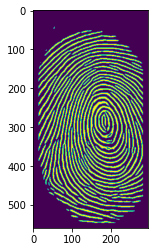

In [ ]:
plt.imshow(zhangSuen(out))